# The transformer architecture

## Needed libraries

In [60]:
# Installe PyTorch (et les dépendances audio/vision souvent utilisées)
!pip install torch torchvision torchaudio

In [61]:
from collections.abc import Iterable
from timeit import default_timer as timer
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import Tensor, nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset

In [62]:
from written_numbers_dataset import NumberDataset

## Dataset

In [63]:
# Define a training set and a test set for a dataset.
# Number of sequences generated for the training set
train_set = NumberDataset()
test_set = NumberDataset(n_numbers=1000)

## Vocabularies

We then need to have a way to navigate back and forth between the token
and its index in the target and source vocabulary. Here the vocabulary
is already known and can be retrieve from the train set
`train_set.vocab_src` and `train_set.vocab_tgt`.

We will also need four different special tokens:

-   A token for unknown words
-   A padding token
-   A token indicating the beginning of a sequence
-   A token indicating the end of a sequence

In [64]:
special_tokens = ["<unk>", "<pad>", "<bos>", "<eos>"]
# Make a list of unique tokens and dictionary that maps tokens to
# their index in that list.
idx2tok_src = special_tokens + train_set.vocab_src
tok2idx_src = {token : i for i, token in enumerate(idx2tok_src)}
idx2tok_tgt = special_tokens + train_set.vocab_tgt
tok2idx_tgt = {token : i for i, token in enumerate(idx2tok_tgt)}
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = [tok2idx_src[tok] for tok in special_tokens]

## Collate function

The collate function is needed to convert a list of samples from their
raw form to a Tensor that a Pytorch model can consume. There are two
different tasks:

-   numericalizing the sequence: changing each token in its index in the
    vocabulary using the `tok2idx_src` and `tok2idx_tgt` dictionaries
    defined earlier
-   pad sequence so that they have the same length, see
    [here](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html)

In [65]:
def collate_fn(batch: List):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:

        # Numericalize list of tokens using `vocab`.
        #
        # - Don't forget to add beginning of sequence and end of sequence tokens
        #   before numericalizing.
        #
        # - Use `torch.LongTensor` instead of `torch.Tensor` because the next
        #   step is an embedding that needs integers for its lookup table.
        src_tensor = torch.LongTensor([tok2idx_src[tok] for tok in ["<bos>"] + src_sample + ["<eos>"]])
        tgt_tensor = torch.LongTensor([tok2idx_tgt[tok] for tok in ["<bos>"] + tgt_sample + ["<eos>"]])

        # Append numericalized sequence to `src_batch` and `tgt_batch`
        src_batch.append(src_tensor)
        tgt_batch.append(tgt_tensor)

    # Turn `src_batch` and `tgt_batch` that are lists of 1-dimensional
    # tensors of varying sizes into tensors with same size with
    # padding. Use `pad_sequence` with padding value to do so.
    #
    # Important notice: by default resulting tensors are of size
    # `max_seq_length` * `batch_size`; the mini-batch size is on the
    # *second dimension*.
    src_batch = pad_sequence(src_batch,padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

    return src_batch, tgt_batch

## Hyperparameters

In [66]:
torch.manual_seed(0)

# Size of source and target vocabulary
SRC_VOCAB_SIZE = len(idx2tok_src)
TGT_VOCAB_SIZE = len(idx2tok_tgt)

# Number of epochs
NUM_EPOCHS = 20

# Size of embeddings
EMB_SIZE = 16

# Number of heads for the multihead attention
NHEAD = 1

# Size of hidden layer of FFN
FFN_HID_DIM = 64

# Size of mini-batches
BATCH_SIZE = 1024

# Number of stacked encoder modules
NUM_ENCODER_LAYERS = 1

# Number of stacked decoder modules
NUM_DECODER_LAYERS = 1

## Positional encoding

In [67]:
pos=torch.empty(10,20)
pos[:, 0::2]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [68]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        # Define Tk/2pi for even k between 0 and `emb_size`. Use
        # `torch.arange`.
        Tk_over_2pi = 10000 ** (torch.arange(0, emb_size, 2) / emb_size)

        # Define `t = 0, 1,..., maxlen-1`. Use `torch.arange`.
        t = torch.arange(maxlen) # maxlen commence à 0 donc prends les indices

        # Outer product between `t` and `1/Tk_over_2pi` to have a
        # matrix of size `maxlen` * `emb_size // 2`. Use
        # `torch.outer`.
        outer = torch.outer(t, 1/Tk_over_2pi)

        pos_embedding = torch.empty((maxlen, emb_size))

        # Fill `pos_embedding` with either sine or cosine of `outer`.
        pos_embedding[:, 0::2] = torch.sin(outer)
        pos_embedding[:, 1::2] = torch.cos(outer)

        # Add fake mini-batch dimension to be able to use broadcasting
        # in `forward` method.
        pos_embedding = pos_embedding.unsqueeze(1)

        self.dropout = nn.Dropout(dropout)

        # Save `pos_embedding` when serializing the model even if it is not a
        # set of parameters
        self.register_buffer("pos_embedding", pos_embedding)

    def forward(self, token_embedding: Tensor):
        # `token_embedding` is of size `seq_length` * `batch_size` *
        # `embedding_size`. Use broadcasting to add the positional embedding
        # that is of size `seq_length` * 1 * `embedding_size`.
        seq_length = token_embedding.size(0)
        positional_encoding = token_embedding + self.pos_embedding[:seq_length, :]

        return self.dropout(positional_encoding)

Rôle : Un buffer est un tenseur qui est enregistré dans le modèle (il est sauvegardé lorsque vous enregistrez le modèle avec state_dict).

Pourquoi ? Les encodages positionnels sont pré-calculés et fixes (ils ne changent jamais). Ils doivent être sauvegardés, mais ils ne doivent jamais être mis à jour par l'optimiseur pendant l'entraînement, contrairement aux poids du modèle (nn.Parameter). register_buffer assure ce comportement.

Le slicing ([:seq_length, :]) sélectionne uniquement les lignes d'encodage nécessaires, allant de la position $0$ jusqu'à la position $\text{seq\_length} - 1$.

## Transformer model

In [69]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
            self,
            num_encoder_layers: int,
            num_decoder_layers: int,
            emb_size: int,
            nhead: int,
            src_vocab_size: int,
            tgt_vocab_size: int,
            dim_feedforward: int = 512,
            dropout: float = 0.1,
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        # Linear layer to compute a score for all tokens from output
        # of transformer
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        # Embedding for source vocabulary
        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)

        # Embedding for target vocabulary
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)

        # Positional encoding layer
        self.positional_encoding = PositionalEncoding(emb_size,dropout=dropout)

    def forward(
            self,
            src: Tensor,
            trg: Tensor,
            src_mask: Tensor,
            tgt_mask: Tensor,
            src_padding_mask: Tensor,
            tgt_padding_mask: Tensor,
            memory_key_padding_mask: Tensor,
    ):
        # Embed `src` and `trg` tensors and add positional embedding.
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        outs = self.transformer(
            src_emb,
            tgt_emb,
            src_mask,
            tgt_mask,
            None,
            src_padding_mask,
            tgt_padding_mask,
            memory_key_padding_mask,
        )

        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        """Used at test-time only to retrieve attention matrix."""
        return self.transformer.encoder(
            self.positional_encoding(self.src_tok_emb(src)), src_mask
        )

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        """Used at test-time only to retrieve attention matrix."""
        return self.transformer.decoder(
            self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask
        )

    def encode_and_attention(self, src: Tensor, src_mask: Tensor):
        """Used at test-time only to retrieve attention matrix."""

        src_pos = self.positional_encoding(self.src_tok_emb(src))
        self_attn = self.transformer.encoder.layers[-1].self_attn
        att = self_attn(src_pos, src_pos, src_pos, attn_mask=src_mask)[1]
        return self.encode(src, src_mask), att

    def decode_and_attention(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        """Used at test-time only to retrieve attention matrix."""

        # Use first decoder layer
        decoder = self.transformer.decoder.layers[0]

        x = self.positional_encoding(self.tgt_tok_emb(tgt))
        x = decoder.norm1(x + decoder._sa_block(x, tgt_mask, None))
        att = decoder.multihead_attn(x, memory, memory, need_weights=True)[1]

        return self.transformer.decoder(x, memory, tgt_mask), att

## Mask function

In [70]:
def create_mask(src: Tensor, tgt: Tensor):
    # Lengths of source and target sequences
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    # Attention mask for the source. As we have no reason to mask input
    # tokens, we use a mask full of False. You can use `torch.full`.
    src_mask = torch.full((src_seq_len,src_seq_len), False)

    # Attention mask for the target. To prevent a token from receiving
    # attention from future ones, we use a mask as defined in the lecture
    # (matrix `M`). You can use `torch.triu` and `torch.full` or directly
    # use the static function `generate_square_subsequent_mask` from the
    # `Transformer` class.
    tgt_mask = Transformer.generate_square_subsequent_mask(tgt_seq_len)

    # Boolean masks identifying tokens that have been padded with
    # `PAD_IDX`. Use `src` and `tgt` to create them. Don't forget to
    # ajust the size since both `src` and `tgt` are of size
    # `batch_size` * `seq_len` and the transformer object needs masks
    # of size `seq_len` * `batch_size`.
    src_padding_mask = (src == PAD_IDX).transpose(0,1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0,1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Training function

[:-1] (Le Slicing) : Cette notation signifie "commence au début (implicitement l'index 0), et va jusqu'à l'élément d'index -1 (le dernier) sans l'inclure".
: (Toutes les colonnes) : La partie , : signifie que, pour chaque ligne sélectionnée (la dimension des séquences), on prend toutes les colonnes (la dimension du batch).

In [71]:
def train_epoch(model: nn.Module, dataset: Dataset, optimizer: Optimizer):
    # Training mode
    model.train()

    # Set loss function to use. Don't forget to tell the loss function to
    # ignore entries that are padded.
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Turn `dataset` into an iterable on mini-batches using `DataLoader`.
    train_dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,collate_fn=collate_fn)

    losses = 0
    for src, tgt in train_dataloader:
        # Select all but the last element of each sequence in `tgt`
        tgt_input = tgt[:-1,:] # derniere ligne = entrée decodeur

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input
        )

        scores = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
        )

        # Resetting gradients
        optimizer.zero_grad()

        # Select all but the first element of each sequence in `tgt`
        tgt_out = tgt[1:,:]

        # Permute dimensions before cross-entropy loss:
        #
        # - `logits` is `seq_length` * `batch_size` * `vocab_size` and should be
        #   `batch_size` * `vocab_size` * `seq_length`
        # - `tgt_out` is `seq_length` * `batch_size` and should be
        #   `batch_size` * `seq_length`
        loss = loss_fn(scores.permute([1,2,0]), tgt_out.permute([1,0]))

        # Back-propagation through loss function
        loss.backward()

        # Gradient descent update
        optimizer.step()

        losses += loss.item()

    return losses / len(dataset)

## Evaluation function

In [72]:
def evaluate(model: nn.Module, val_dataset: Dataset):
    model.eval()

    # Set loss function to use. Don't forget to tell the loss function to
    # ignore entries that are padded.
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    # Turn dataset into an iterable on batches
    val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE ,collate_fn=collate_fn)

    losses = 0
    for src, tgt in val_dataloader:
        # Select all but the last element of each sequence in `tgt`
        tgt_input = tgt[:-1,:]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input
        )

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask,
        )

        # Select all but the first element of each sequence in `tgt`
        tgt_out = tgt[1:,:]

        # Permute dimensions for cross-entropy loss:
        #
        # - `logits` is `seq_length` * `batch_size` * `vocab_size` and should be
        #   `batch_size` * `vocab_size` * `seq_length`
        # - `tgt_out` is `seq_length` * `batch_size` and should be
        #   `batch_size` * `seq_length`
        loss = loss_fn(logits.permute([1,2,0]),tgt_out.permute([1,0]))

        losses += loss.item()

    return losses / len(val_dataset)

## Learning loop

In [73]:
transformer = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM,
)

optimizer = Adam(transformer.parameters(), lr=0.001)

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, train_set, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer, test_set)
    print(
        (
            f"Epoch: {epoch}, Train loss: {train_loss:.5f}, Val loss: {val_loss:.5f}, "
            f"Epoch time = {(end_time - start_time):.3f}s"
        )
    )

/opt/anaconda3/envs/SY09_Project/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/opt/anaconda3/envs/SY09_Project/lib/python3.11/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 0.00307, Val loss: 0.00286, Epoch time = 5.476s
Epoch: 2, Train loss: 0.00272, Val loss: 0.00256, Epoch time = 5.321s
Epoch: 3, Train loss: 0.00247, Val loss: 0.00232, Epoch time = 5.691s
Epoch: 4, Train loss: 0.00229, Val loss: 0.00213, Epoch time = 5.371s
Epoch: 5, Train loss: 0.00214, Val loss: 0.00194, Epoch time = 5.288s
Epoch: 6, Train loss: 0.00201, Val loss: 0.00179, Epoch time = 5.337s
Epoch: 7, Train loss: 0.00190, Val loss: 0.00166, Epoch time = 5.279s
Epoch: 8, Train loss: 0.00182, Val loss: 0.00156, Epoch time = 5.232s
Epoch: 9, Train loss: 0.00175, Val loss: 0.00147, Epoch time = 5.339s
Epoch: 10, Train loss: 0.00169, Val loss: 0.00139, Epoch time = 5.323s
Epoch: 11, Train loss: 0.00163, Val loss: 0.00132, Epoch time = 5.221s
Epoch: 12, Train loss: 0.00158, Val loss: 0.00125, Epoch time = 5.303s
Epoch: 13, Train loss: 0.00154, Val loss: 0.00118, Epoch time = 5.304s
Epoch: 14, Train loss: 0.00149, Val loss: 0.00112, Epoch time = 5.306s
Epoch: 15, Trai

## Helpers functions

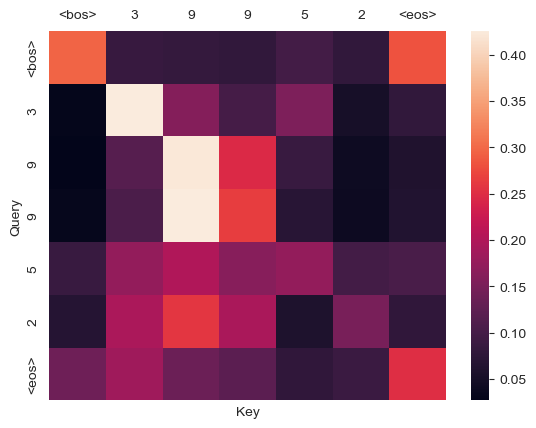

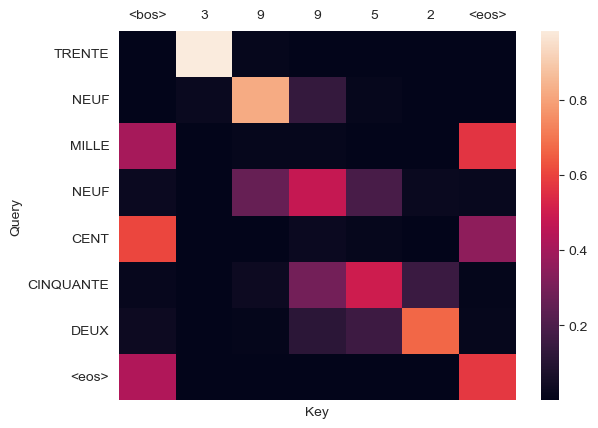

In [74]:
def greedy_decode(model, src, src_mask, start_symbol_idx):
    """Autoregressive decoding of `src` starting with `start_symbol_idx`."""

    memory, att = model.encode_and_attention(src, src_mask)
    ys = torch.LongTensor([[start_symbol_idx]])
    maxlen = 100

    for i in range(maxlen):
        tgt_mask = Transformer.generate_square_subsequent_mask(ys.size(0))

        # Decode `ys`. `out` is of size `curr_len` * 1 * `vocab_size`
        out = model.decode(ys, memory, tgt_mask)

        # Select encoding of last token
        enc = out[-1, 0, :]

        # Get a set of scores on vocabulary
        dist = model.generator(enc)

        # Get index of maximum
        idx = torch.argmax(dist).item()

        # Add predicted index to `ys`
        ys = torch.cat((ys, torch.LongTensor([[idx]])))

        if idx == EOS_IDX:
            break
    return ys, att


def translate(model: torch.nn.Module, src_sentence: Iterable):
    """Translate sequence `src_sentence` with `model`."""

    model.eval()

    # Numericalize source
    src_tensor = torch.LongTensor([tok2idx_src[tok] for tok in ["<bos>"] + list(src_sentence) + ["<eos>"]])

    # Fake a minibatch of size one
    src = src_tensor.unsqueeze(-1)

    # No mask for source sequence
    seq_length = src.size(0)
    src_mask = torch.full((seq_length, seq_length), False)

    # Translate `src`
    tgt_tokens, att = greedy_decode(model, src, src_mask, BOS_IDX)

    tgt_tokens = tgt_tokens.flatten().numpy()
    att = att.detach().squeeze().numpy()
    return " ".join(idx2tok_tgt[idx] for idx in tgt_tokens), att


def plot_encoder_attention_matrix(model, src):
    """Plot heatmap of encoder's attention matrix."""

    model.eval()

    # Numericalize source
    src_delim = ["<bos>"] + list(src) + ["<eos>"]
    src_tensor = torch.LongTensor([tok2idx_src[tok] for tok in src_delim])

    # Fake a minibatch of size one
    src = src_tensor.unsqueeze(-1)

    # No mask for source sequence
    seq_length = src.size(0)
    src_mask = torch.full((seq_length, seq_length), False)

    # Translate `src`
    memory, att = model.encode_and_attention(src, src_mask)

    ax = sns.heatmap(
        att.detach().squeeze().numpy(),
        xticklabels=src_delim,
        yticklabels=src_delim,
    )
    ax.set(xlabel='Key', ylabel='Query')

    ax.tick_params(
        axis="both",
        which="major",
        labelsize=10,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )

def plot_decoder_attention_matrix(model, src, tgt):
    """Plot heatmap of decoder's cross-attention matrix."""

    model.eval()

    # Numericalize source and target
    src_delim = ["<bos>"] + list(src) + ["<eos>"]
    src_tensor = torch.LongTensor([tok2idx_src[tok] for tok in src_delim])
    tgt_delim = ["<bos>"] + list(tgt) + ["<eos>"]
    tgt_tensor = torch.LongTensor([tok2idx_tgt[tok] for tok in tgt_delim])

    # Fake a minibatch of size one
    src = src_tensor.unsqueeze(-1)
    tgt = tgt_tensor.unsqueeze(-1)

    # No mask for source sequence and triangular mask to target
    seq_length = src.size(0)
    src_mask = torch.full((seq_length, seq_length), False)
    tgt_mask = Transformer.generate_square_subsequent_mask(tgt.size(0))

    # Encode `src`
    memory = model.encode(src, src_mask)

    # Retrieve cross-attention matrix
    _, att = model.decode_and_attention(tgt, memory, tgt_mask)

    att_matrix = att.squeeze()[:-1, :].detach().numpy()

    ax = sns.heatmap(
        att_matrix,
        xticklabels=src_delim,
        yticklabels=tgt_delim[1:],
    )
    ax.set(xlabel='Key', ylabel='Query')

    ax.tick_params(
        axis="both",
        which="major",
        labelsize=10,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )


src, tgt = test_set[0]
pred, att = translate(transformer, src)

plot_encoder_attention_matrix(transformer, src)
plt.show()

plot_decoder_attention_matrix(transformer, src, tgt)
plt.show()

In [83]:
from torch.utils.data import Dataset
from typing import List

def print_dataset_summary(dataset: Dataset, name: str, max_samples: int = 10):
    """
    Affiche les N premiers échantillons d'un ensemble de données Seq2Seq.

    Args:
        dataset: L'ensemble de données à afficher (train_set ou test_set).
        name: Le nom de l'ensemble ('train_set' ou 'test_set').
        max_samples: Nombre maximum d'échantillons à afficher.
    """
    
    # Limite le nombre d'échantillons à afficher
    num_to_display = min(len(dataset), max_samples)
    
    print(f"\n=======================================================")
    print(f"--- Aperçu des {num_to_display} premiers échantillons du {name} ---")
    print(f"Total d'échantillons dans {name}: {len(dataset)}")
    print("=======================================================")
    print("| Index | Source (Mots) | Cible (Chiffres) | Longueur SRC | Longueur TGT |")
    print("|-------|---------------|------------------|--------------|--------------|")

    for i in range(num_to_display):
        # Récupère l'échantillon (paire de listes de strings)
        src_sequence, tgt_sequence = dataset[i]
        
        src_str = " ".join(src_sequence)
        tgt_str = " ".join(tgt_sequence)
        
        len_src = len(src_sequence)
        len_tgt = len(tgt_sequence)
        
        # Affichage formaté
        print(
            f"| {str(i).ljust(5)} | "
            f"{src_str.ljust(13)} | "
            f"{tgt_str.ljust(16)} | "
            f"{str(len_src).center(12)} | "
            f"{str(len_tgt).center(12)} |"
        )

    print("=======================================================")
    
# --- Utilisation de la fonction ---

# Assurez-vous que train_set et test_set sont définis et accessibles
# (comme dans la cellule où vous les avez initialisés)

#
print_dataset_summary(train_set, "train_set", max_samples=5)
print_dataset_summary(test_set, "test_set", max_samples=5)


--- Aperçu des 5 premiers échantillons du train_set ---
Total d'échantillons dans train_set: 50000
| Index | Source (Mots) | Cible (Chiffres) | Longueur SRC | Longueur TGT |
|-------|---------------|------------------|--------------|--------------|
| 0     | 1 4 1 3 0 1 9 6 4 8 8 1 7 | MILLE MILLIARD QUATRE CENT TREIZE MILLIARD DIX NEUF MILLION SIX CENT QUARANTE HUIT MILLE HUIT CENT DIX SEPT |      13      |      18      |
| 1     | 3 8 3 7 2 5 2 | TROIS MILLION HUIT CENT TRENTE SEPT MILLE DEUX CENT CINQUANTE DEUX |      7       |      11      |
| 2     | 3 6 7         | TROIS CENT SOIXANTE SEPT |      3       |      4       |
| 3     | 5 1 5 6 7 2 0 | CINQ MILLION CENT CINQUANTE SIX MILLE SEPT CENT VINGT |      7       |      9       |
| 4     | 3 5 7 7 3 4 9 5 6 3 | TROIS MILLIARD CINQ CENT SOIXANTE DIX SEPT MILLION TROIS CENT QUARANTE NEUF MILLE CINQ CENT SOIXANTE TROIS |      10      |      17      |

--- Aperçu des 5 premiers échantillons du test_set ---
Total d'échantillons dans

--- Résultat de la traduction ---
Phrase Source (Input): 3 9 9 5 2
Phrase Cible Attendue (Ground Truth): TRENTE NEUF MILLE NEUF CENT CINQUANTE DEUX
Prédiction du Modèle (Output): <bos> TROIS CENT QUATRE VINGT NEUF MILLE DEUX CENT VINGT NEUF <eos>


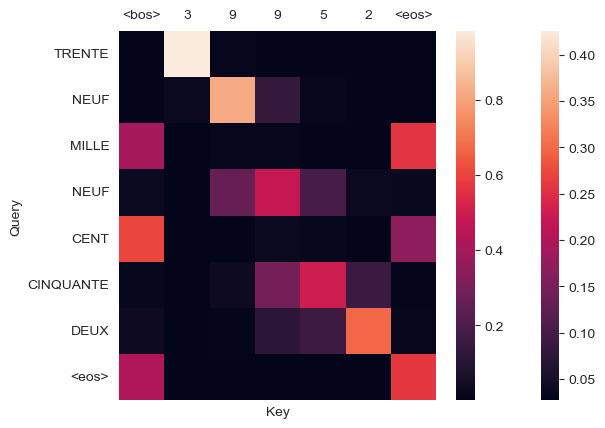

In [76]:
# ==============================================================================
# Cellule de test de traduction
# ==============================================================================

# Choisissez une séquence source. 
# Si vous utilisez les données du notebook, vous pouvez prendre un exemple du test_set.
src_test, tgt_test = test_set[0] 

# Exécute la traduction
prediction, attention_matrix = translate(transformer, src_test)

print(f"--- Résultat de la traduction ---")
print(f"Phrase Source (Input): {' '.join(src_test)}")
print(f"Phrase Cible Attendue (Ground Truth): {' '.join(tgt_test)}")
print(f"Prédiction du Modèle (Output): {prediction}")

# Affichage des matrices d'attention
plot_encoder_attention_matrix(transformer, src_test)
plot_decoder_attention_matrix(transformer, src_test, tgt_test)